# Proyecto TRM - Analisis de Residual

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from scipy import stats
import numpy as np
from statsmodels.graphics.tsaplots import plot_predict

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

In [2]:
from pathlib import Path

base = Path('.')
candidates = list(base.glob('**/Tasa*colombiano*.*'))
if not candidates:
    raise FileNotFoundError('No se encontró el archivo de tasa de cambio en el repositorio')
file_path = candidates[0]
print(f'Usando archivo: {file_path}')
if file_path.suffix.lower() in ('.xls', '.xlsx'):
    df = pd.read_excel(file_path)
else:
    df = pd.read_csv(file_path, encoding='latin1', sep=';')

Usando archivo: Tasa de cambio del peso colombiano .xlsx


In [3]:
df_clean = df.iloc[8857-730:8857]
df_clean = df_clean.reset_index(drop=True)
# df_clean = df.iloc[:8857]

In [4]:
# Seleccionamos las columnas y filas de interes para hacer los calculos con pandas
df_preprocessed = df_clean[['periodo', 'trm']]
df_preprocessed

# Se hace el calculo de primera y segunda diferencia
df_preprocessed['primera_dif'] = df_preprocessed['trm'].diff()
df_preprocessed['segunda_dif'] =df_preprocessed['trm'] - df_preprocessed['trm'].shift(2)

/tmp/ipykernel_23811/601938330.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['primera_dif'] = df_preprocessed['trm'].diff()
/tmp/ipykernel_23811/601938330.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['segunda_dif'] =df_preprocessed['trm'] - df_preprocessed['trm'].shift(2)


In [5]:
# Se calcula el valor minimo, maximo, promedio y desviacion estandar de la primera diferencia
min_diff = df_preprocessed['primera_dif'].min()
max_diff = df_preprocessed['primera_dif'].max()
mean_diff = df_preprocessed['primera_dif'].mean()
std_diff = df_preprocessed['primera_dif'].std()
min_trm = df_preprocessed['trm'].min()
max_trm = df_preprocessed['trm'].max()
min_diff, max_diff, mean_diff, std_diff

(np.float64(-154.6899999999996),
 np.float64(144.01999999999953),
 np.float64(-1.1582716049382724),
 np.float64(32.62069875697272))

In [6]:
df_preprocessed['trans_max_min_primera_dif'] = (df_preprocessed['primera_dif'] - min_diff) / (max_diff - min_diff)
df_preprocessed['estandarizacion'] = (df_preprocessed['primera_dif'] - mean_diff) / std_diff
# Normalización min-max de la columna trm
df_preprocessed['trans_max_min_trm'] = (df_preprocessed['trm'] - min_trm) / (max_trm - min_trm)
df_preprocessed['primera_dif_trans_max_min_trm'] = df_preprocessed['trans_max_min_trm'].diff()


/tmp/ipykernel_23811/241726627.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['trans_max_min_primera_dif'] = (df_preprocessed['primera_dif'] - min_diff) / (max_diff - min_diff)
/tmp/ipykernel_23811/241726627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['estandarizacion'] = (df_preprocessed['primera_dif'] - mean_diff) / std_diff
/tmp/ipykernel_23811/241726627.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [7]:
# Se agregan lo rezagos
df_preprocessed['y_t'] = df_preprocessed['trm'].diff()
df_preprocessed['y_t-1'] = df_preprocessed['y_t'].shift(1)
df_preprocessed['y_t-2'] = df_preprocessed['y_t-1'].shift(1)
df_preprocessed['y_t-3'] = df_preprocessed['y_t-2'].shift(1)


/tmp/ipykernel_23811/98760068.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['y_t'] = df_preprocessed['trm'].diff()
/tmp/ipykernel_23811/98760068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['y_t-1'] = df_preprocessed['y_t'].shift(1)
/tmp/ipykernel_23811/98760068.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [8]:
# Promedios moviles (ventana de 2 filas incluyendo la actual)
df_preprocessed['m_1'] = df_preprocessed['y_t'].rolling(window=2, min_periods=2).mean()
df_preprocessed['m_2'] = df_preprocessed['y_t'].rolling(window=3, min_periods=3).mean()
df_preprocessed['m_3'] = df_preprocessed['y_t'].rolling(window=4, min_periods=4).mean()

/tmp/ipykernel_23811/923652204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['m_1'] = df_preprocessed['y_t'].rolling(window=2, min_periods=2).mean()
/tmp/ipykernel_23811/923652204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['m_2'] = df_preprocessed['y_t'].rolling(window=3, min_periods=3).mean()
/tmp/ipykernel_23811/923652204.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [9]:
df_preprocessed

,periodo,trm,primera_dif,segunda_dif,trans_max_min_primera_dif,estandarizacion,trans_max_min_trm,primera_dif_trans_max_min_trm,y_t,y_t-1,y_t-2,y_t-3,m_1,m_2,m_3
0,2023-01-20,4683.85,NaN,NaN,NaN,NaN,0.765168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-23,4631.64,-52.21,NaN,0.343075,-1.565010,0.721764,-0.043403,-52.21,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-24,4551.02,-80.62,-132.83,0.247966,-2.435930,0.654743,-0.067021,-80.62,-52.21,NaN,NaN,-66.415,NaN,NaN
3,2023-01-25,4545.94,-5.08,-85.70,0.500854,-0.120222,0.650520,-0.004223,-5.08,-80.62,-52.21,NaN,-42.850,-45.970000,NaN
4,2023-01-26,4538.91,-7.03,-12.11,0.494326,-0.180000,0.644675,-0.005844,-7.03,-5.08,-80.62,-52.21,-6.055,-30.910000,-36.2350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2025-10-31,3870.42,-14.87,-4.42,0.468079,-0.420338,0.088943,-0.012362,-14.87,10.45,30.64,-14.43,-2.210,8.740000,2.9475
726,2025-11-03,3860.12,-10.30,-25.17,0.483379,-0.280243,0.080381,-0.008563,-10.30,-14.87,10.45,30.64,-12.585,-4.906667,3.9800
727,2025-11-04,3860.12,0.00,-10.30,0.517860,0.035507,0.080381,0.000000,0.00,-10.30,-14.87,10.45,-5.150,-8.390000,-3.6800
728,2025-11-05,3872.47,12.35,12.35,0.559205,0.414101,0.090648,0.010267,12.35,0.00,-10.30,-14.87,6.175,0.683333,-3.2050


## Análisis Exploratorio de Datos (EDA)

In [10]:
# Información general del dataset
print("=" * 60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 60)
print(f"\nCantidad de registros: {len(df_preprocessed)}")
print(f"Cantidad de columnas: {len(df_preprocessed.columns)}")
print(f"\nColumnas: {list(df_preprocessed.columns)}")
print(f"\nRango de fechas: {df_preprocessed['periodo'].min()} a {df_preprocessed['periodo'].max()}")
print(f"\nValores nulos por columna:")
print(df_preprocessed.isnull().sum())

INFORMACIÓN GENERAL DEL DATASET

Cantidad de registros: 730
Cantidad de columnas: 15

Columnas: ['periodo', 'trm', 'primera_dif', 'segunda_dif', 'trans_max_min_primera_dif', 'estandarizacion', 'trans_max_min_trm', 'primera_dif_trans_max_min_trm', 'y_t', 'y_t-1', 'y_t-2', 'y_t-3', 'm_1', 'm_2', 'm_3']

Rango de fechas: 2023-01-20 00:00:00 a 2025-11-06 00:00:00

Valores nulos por columna:
periodo                          0
trm                              0
primera_dif                      1
segunda_dif                      2
trans_max_min_primera_dif        1
estandarizacion                  1
trans_max_min_trm                0
primera_dif_trans_max_min_trm    1
y_t                              1
y_t-1                            2
y_t-2                            3
y_t-3                            4
m_1                              2
m_2                              3
m_3                              4
dtype: int64


In [11]:
# Estadísticas descriptivas de las variables principales
print("\n" + "=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS - TRM")
print("=" * 60)
print(df_preprocessed['trm'].describe())

print("\n" + "=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS - PRIMERA DIFERENCIA")
print("=" * 60)
print(df_preprocessed['primera_dif'].describe())

print("\n" + "=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS - SEGUNDA DIFERENCIA")
print("=" * 60)
print(df_preprocessed['segunda_dif'].describe())


ESTADÍSTICAS DESCRIPTIVAS - TRM
count     730.000000
mean     4158.010452
std       248.679498
min      3763.430000
25%      3958.535000
50%      4111.450000
75%      4281.985000
max      4966.330000
Name: trm, dtype: float64

ESTADÍSTICAS DESCRIPTIVAS - PRIMERA DIFERENCIA
count    729.000000
mean      -1.158272
std       32.620699
min     -154.690000
25%      -20.890000
50%       -0.450000
75%       14.860000
max      144.020000
Name: primera_dif, dtype: float64

ESTADÍSTICAS DESCRIPTIVAS - SEGUNDA DIFERENCIA
count    728.000000
mean      -2.202679
std       49.832525
min     -174.160000
25%      -33.560000
50%       -5.355000
75%       23.827500
max      244.520000
Name: segunda_dif, dtype: float64


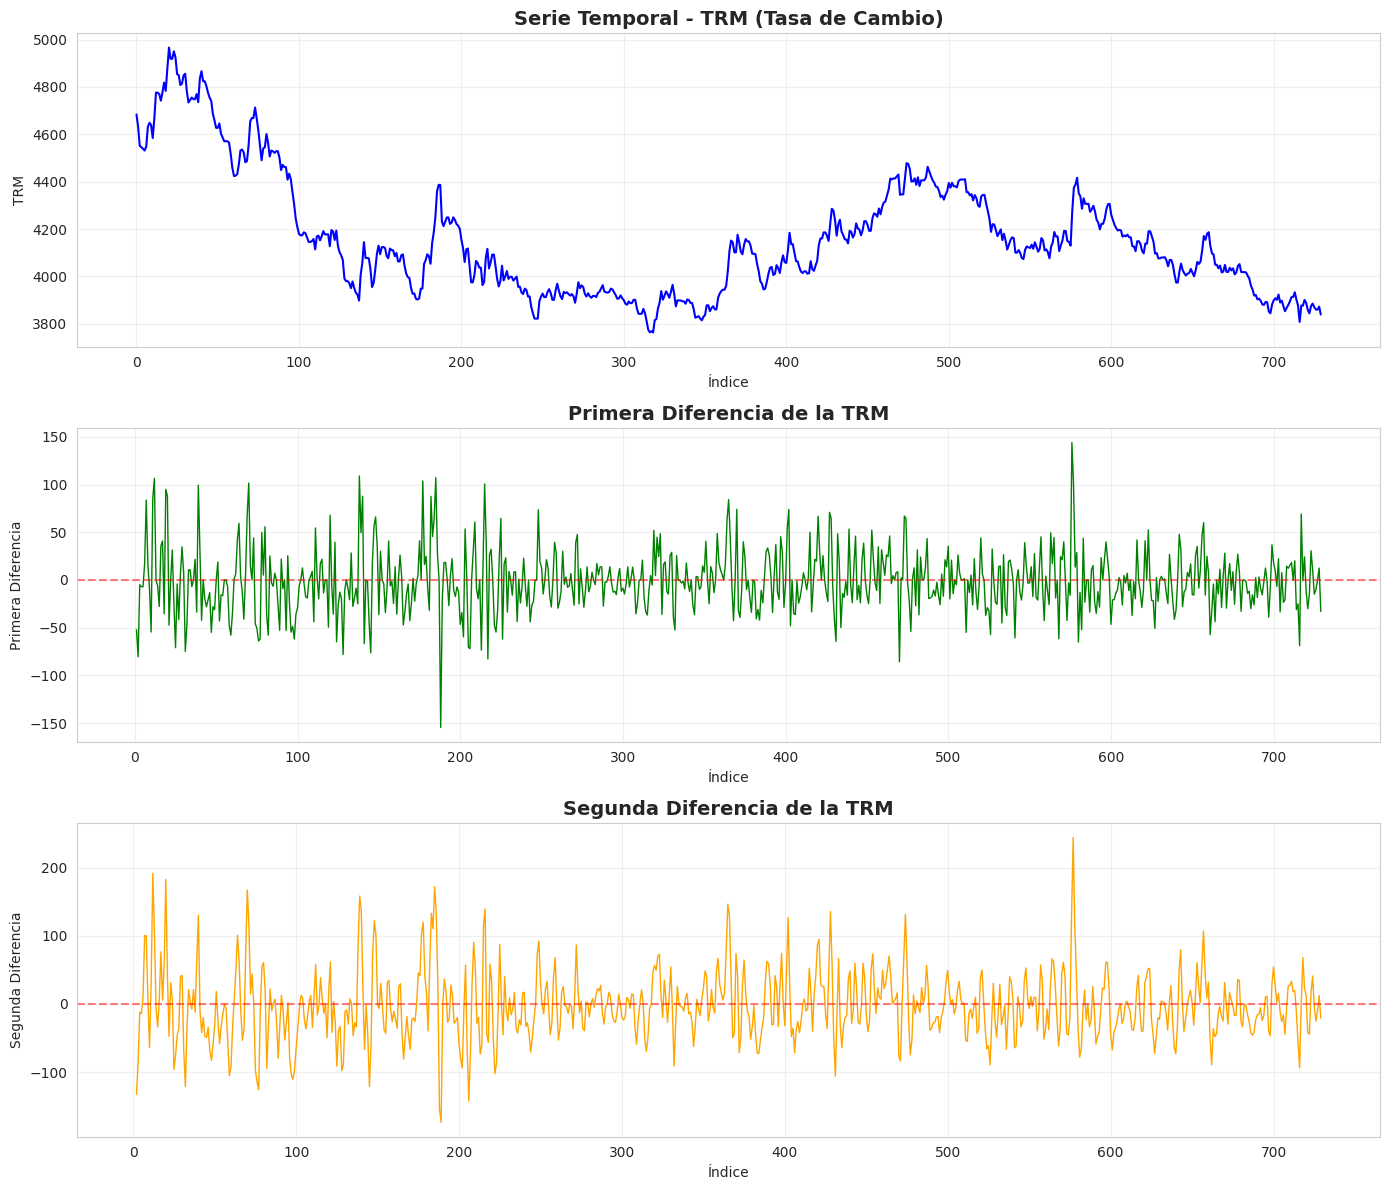

In [12]:
# Serie temporal de la TRM
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# TRM original
axes[0].plot(df_preprocessed.index, df_preprocessed['trm'], color='blue', linewidth=1.5)
axes[0].set_title('Serie Temporal - TRM (Tasa de Cambio)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Índice')
axes[0].set_ylabel('TRM')
axes[0].grid(True, alpha=0.3)

# Primera diferencia
axes[1].plot(df_preprocessed.index, df_preprocessed['primera_dif'], color='green', linewidth=1)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_title('Primera Diferencia de la TRM', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Índice')
axes[1].set_ylabel('Primera Diferencia')
axes[1].grid(True, alpha=0.3)

# Segunda diferencia
axes[2].plot(df_preprocessed.index, df_preprocessed['segunda_dif'], color='orange', linewidth=1)
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].set_title('Segunda Diferencia de la TRM', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Índice')
axes[2].set_ylabel('Segunda Diferencia')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

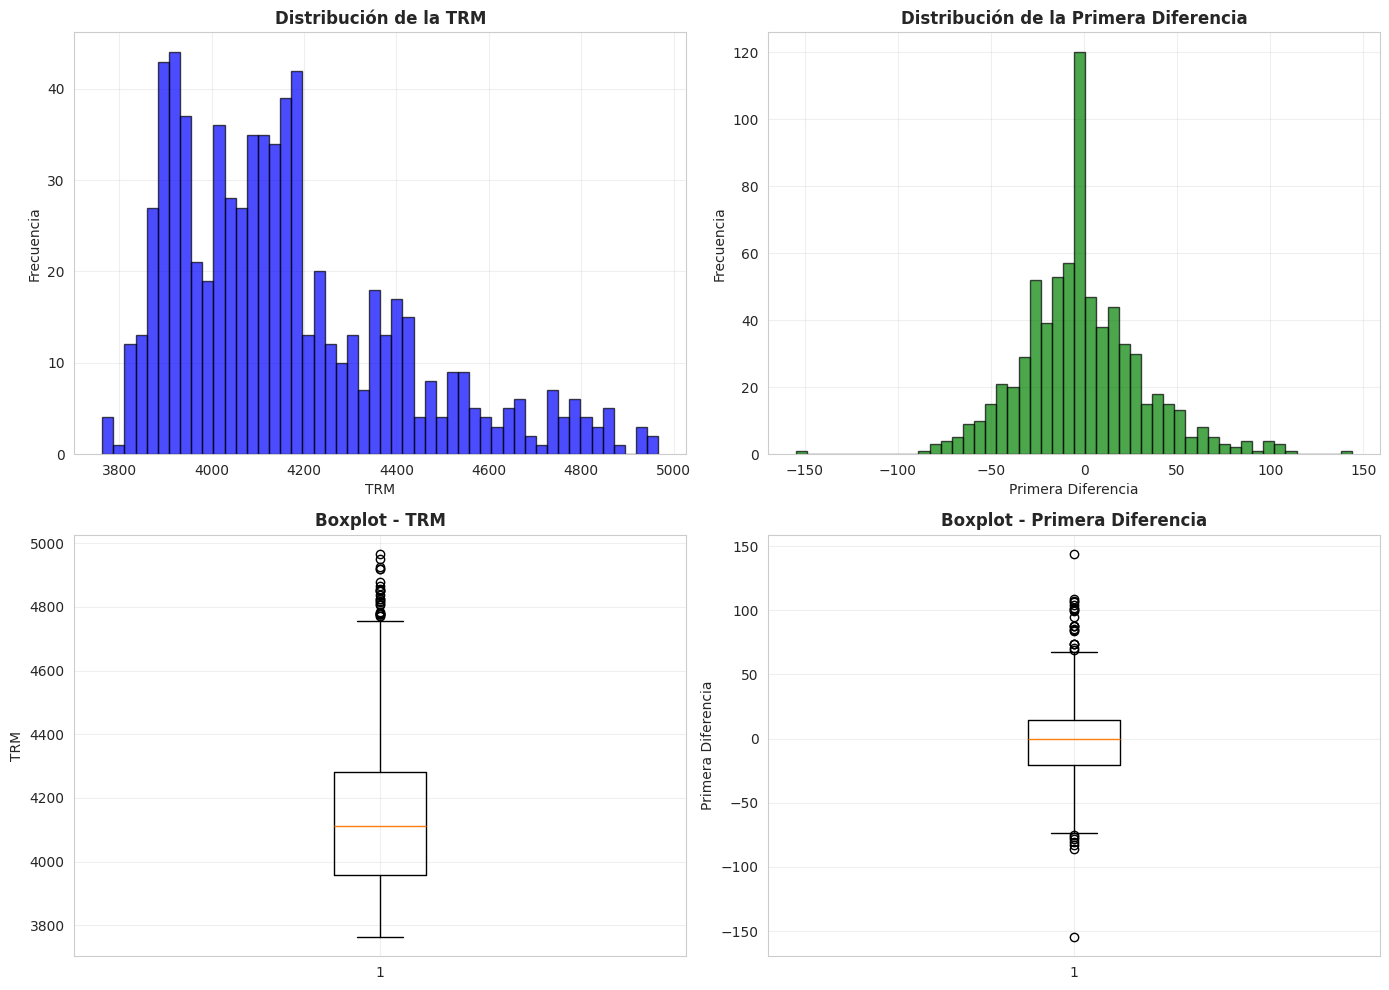

In [13]:
# Histogramas y distribuciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograma TRM
axes[0, 0].hist(df_preprocessed['trm'].dropna(), bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribución de la TRM', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('TRM')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

# Histograma primera diferencia
axes[0, 1].hist(df_preprocessed['primera_dif'].dropna(), bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribución de la Primera Diferencia', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Primera Diferencia')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(True, alpha=0.3)

# Boxplot TRM
axes[1, 0].boxplot(df_preprocessed['trm'].dropna(), vert=True)
axes[1, 0].set_title('Boxplot - TRM', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('TRM')
axes[1, 0].grid(True, alpha=0.3)

# Boxplot primera diferencia
axes[1, 1].boxplot(df_preprocessed['primera_dif'].dropna(), vert=True)
axes[1, 1].set_title('Boxplot - Primera Diferencia', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Primera Diferencia')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

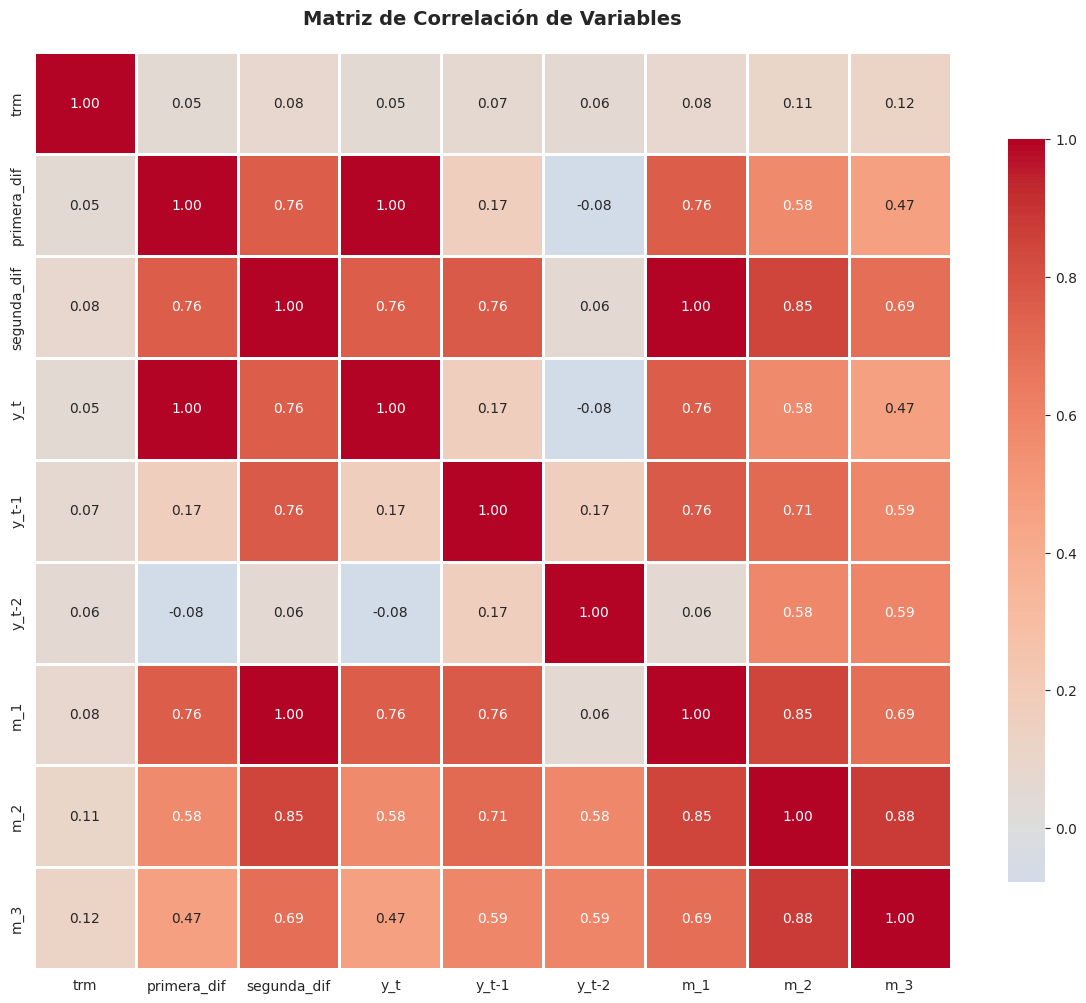

In [14]:
# Matriz de correlación
correlation_cols = ['trm', 'primera_dif', 'segunda_dif', 'y_t', 'y_t-1', 'y_t-2', 'm_1', 'm_2', 'm_3']
corr_matrix = df_preprocessed[correlation_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación de Variables', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

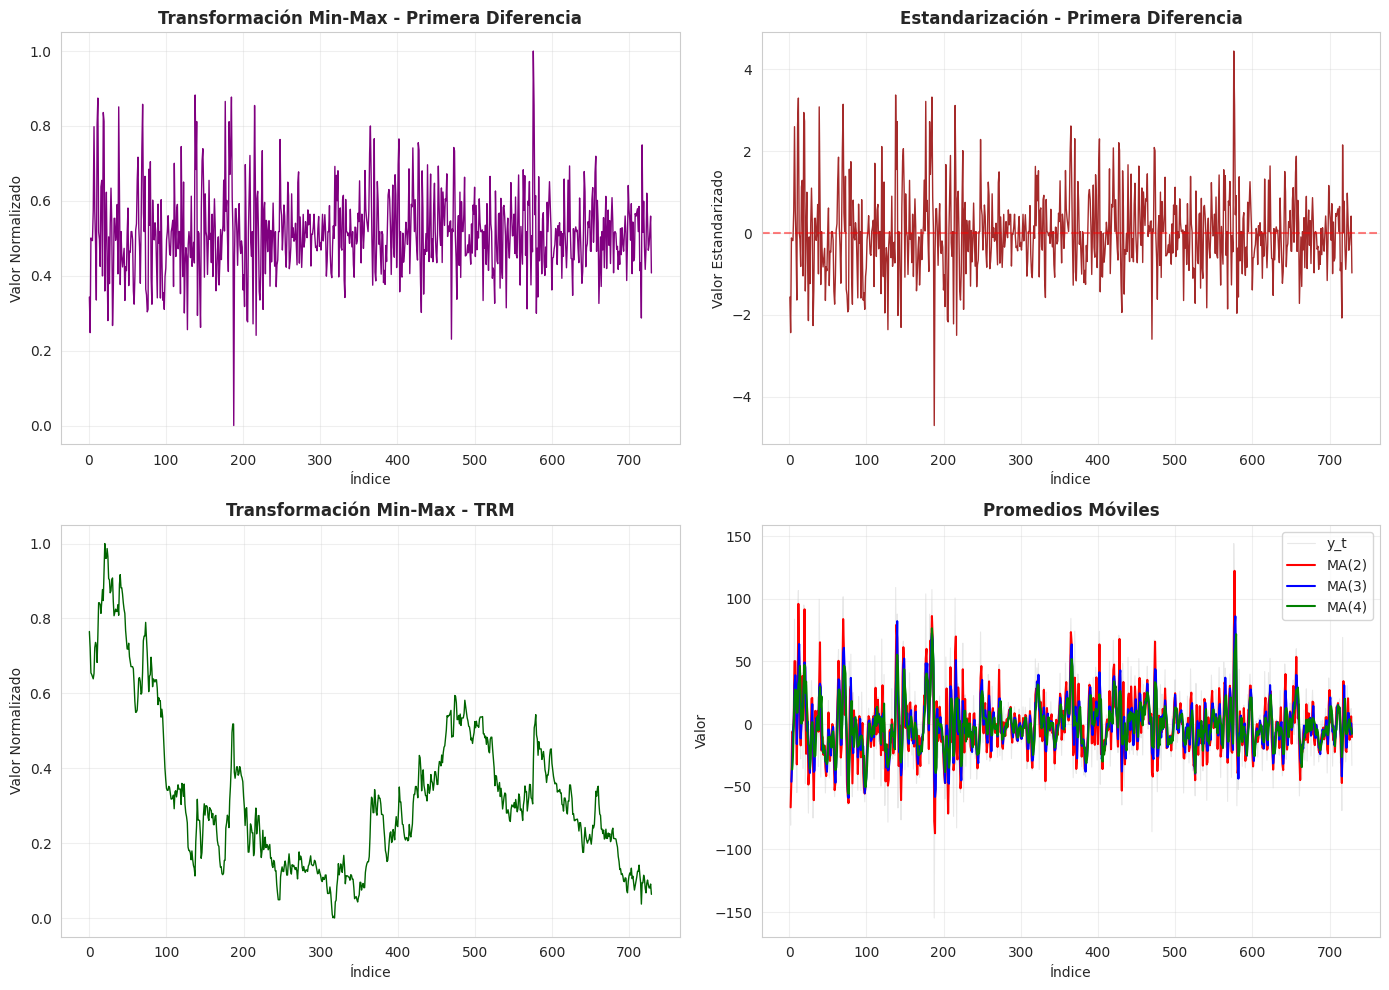

In [15]:
# Análisis de normalización y estandarización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Transformación min-max de primera diferencia
axes[0, 0].plot(df_preprocessed.index, df_preprocessed['trans_max_min_primera_dif'], 
                color='purple', linewidth=1)
axes[0, 0].set_title('Transformación Min-Max - Primera Diferencia', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Índice')
axes[0, 0].set_ylabel('Valor Normalizado')
axes[0, 0].grid(True, alpha=0.3)

# Estandarización
axes[0, 1].plot(df_preprocessed.index, df_preprocessed['estandarizacion'], 
                color='brown', linewidth=1)
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_title('Estandarización - Primera Diferencia', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Índice')
axes[0, 1].set_ylabel('Valor Estandarizado')
axes[0, 1].grid(True, alpha=0.3)

# TRM normalizado
axes[1, 0].plot(df_preprocessed.index, df_preprocessed['trans_max_min_trm'], 
                color='darkgreen', linewidth=1)
axes[1, 0].set_title('Transformación Min-Max - TRM', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Índice')
axes[1, 0].set_ylabel('Valor Normalizado')
axes[1, 0].grid(True, alpha=0.3)

# Promedios móviles
axes[1, 1].plot(df_preprocessed.index, df_preprocessed['y_t'], 
                color='lightgray', linewidth=0.8, alpha=0.5, label='y_t')
axes[1, 1].plot(df_preprocessed.index, df_preprocessed['m_1'], 
                color='red', linewidth=1.5, label='MA(2)')
axes[1, 1].plot(df_preprocessed.index, df_preprocessed['m_2'], 
                color='blue', linewidth=1.5, label='MA(3)')
axes[1, 1].plot(df_preprocessed.index, df_preprocessed['m_3'], 
                color='green', linewidth=1.5, label='MA(4)')
axes[1, 1].set_title('Promedios Móviles', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Índice')
axes[1, 1].set_ylabel('Valor')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Resumen estadístico final
print("\n" + "=" * 60)
print("RESUMEN DEL ANÁLISIS EXPLORATORIO")
print("=" * 60)

print("\n1. CARACTERÍSTICAS DEL DATASET:")
print(f"   - Total de observaciones: {len(df_preprocessed)}")
print(f"   - Periodo analizado: {df_preprocessed['periodo'].min()} a {df_preprocessed['periodo'].max()}")
print(f"   - Variables generadas: {len(df_preprocessed.columns)}")

print("\n2. TRM (TASA DE CAMBIO):")
print(f"   - Promedio: {df_preprocessed['trm'].mean():.2f}")
print(f"   - Mediana: {df_preprocessed['trm'].median():.2f}")
print(f"   - Mínimo: {df_preprocessed['trm'].min():.2f}")
print(f"   - Máximo: {df_preprocessed['trm'].max():.2f}")
print(f"   - Desviación Estándar: {df_preprocessed['trm'].std():.2f}")

print("\n3. PRIMERA DIFERENCIA:")
print(f"   - Promedio: {df_preprocessed['primera_dif'].mean():.2f}")
print(f"   - Mediana: {df_preprocessed['primera_dif'].median():.2f}")
print(f"   - Rango: [{df_preprocessed['primera_dif'].min():.2f}, {df_preprocessed['primera_dif'].max():.2f}]")
print(f"   - Desviación Estándar: {df_preprocessed['primera_dif'].std():.2f}")

print("\n4. VALORES NULOS:")
print(f"   - Total de valores nulos: {df_preprocessed.isnull().sum().sum()}")
print(f"   - Porcentaje de completitud: {((1 - df_preprocessed.isnull().sum().sum() / (len(df_preprocessed) * len(df_preprocessed.columns))) * 100):.2f}%")

print("\n" + "=" * 60)


RESUMEN DEL ANÁLISIS EXPLORATORIO

1. CARACTERÍSTICAS DEL DATASET:
   - Total de observaciones: 730
   - Periodo analizado: 2023-01-20 00:00:00 a 2025-11-06 00:00:00
   - Variables generadas: 15

2. TRM (TASA DE CAMBIO):
   - Promedio: 4158.01
   - Mediana: 4111.45
   - Mínimo: 3763.43
   - Máximo: 4966.33
   - Desviación Estándar: 248.68

3. PRIMERA DIFERENCIA:
   - Promedio: -1.16
   - Mediana: -0.45
   - Rango: [-154.69, 144.02]
   - Desviación Estándar: 32.62

4. VALORES NULOS:
   - Total de valores nulos: 25
   - Porcentaje de completitud: 99.77%



## Implementacion de modelo ARMA + GARCH

In [17]:
## Limpieza de nulos
df_preprocessed.dropna(inplace=True)
print(df_clean.isnull().sum())

periodo              0
trm                  0
dia                  0
primera_dif          0
segunda_dif          0
trans_max_min        0
estanrazicacion z    0
trans_max_min.1      0
1dif                 0
y_t                  0
y_t-1                0
y_t-2                0
y_t-3                0
m1                   0
m2                   0
m3                   0
m4                   0
m5                   0
dtype: int64


/tmp/ipykernel_23811/4123291156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed.dropna(inplace=True)


In [18]:
df_preprocessed = df_preprocessed.reset_index(drop=True)
df_preprocessed

,periodo,trm,primera_dif,segunda_dif,trans_max_min_primera_dif,estandarizacion,trans_max_min_trm,primera_dif_trans_max_min_trm,y_t,y_t-1,y_t-2,y_t-3,m_1,m_2,m_3
0,2023-01-26,4538.91,-7.03,-12.11,0.494326,-0.180000,0.644675,-0.005844,-7.03,-5.08,-80.62,-52.21,-6.055,-30.910000,-36.2350
1,2023-01-27,4531.75,-7.16,-14.19,0.493890,-0.183985,0.638723,-0.005952,-7.16,-7.03,-5.08,-80.62,-7.095,-6.423333,-24.9725
2,2023-01-30,4548.50,16.75,9.59,0.573935,0.548985,0.652648,0.013925,16.75,-7.16,-7.03,-5.08,4.795,0.853333,-0.6300
3,2023-01-31,4632.20,83.70,100.45,0.798065,2.601363,0.722230,0.069582,83.70,16.75,-7.16,-7.03,50.225,31.096667,21.5650
4,2023-02-01,4648.70,16.50,100.20,0.573098,0.541321,0.735946,0.013717,16.50,83.70,16.75,-7.16,50.100,38.983333,27.4475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,2025-10-31,3870.42,-14.87,-4.42,0.468079,-0.420338,0.088943,-0.012362,-14.87,10.45,30.64,-14.43,-2.210,8.740000,2.9475
722,2025-11-03,3860.12,-10.30,-25.17,0.483379,-0.280243,0.080381,-0.008563,-10.30,-14.87,10.45,30.64,-12.585,-4.906667,3.9800
723,2025-11-04,3860.12,0.00,-10.30,0.517860,0.035507,0.080381,0.000000,0.00,-10.30,-14.87,10.45,-5.150,-8.390000,-3.6800
724,2025-11-05,3872.47,12.35,12.35,0.559205,0.414101,0.090648,0.010267,12.35,0.00,-10.30,-14.87,6.175,0.683333,-3.2050


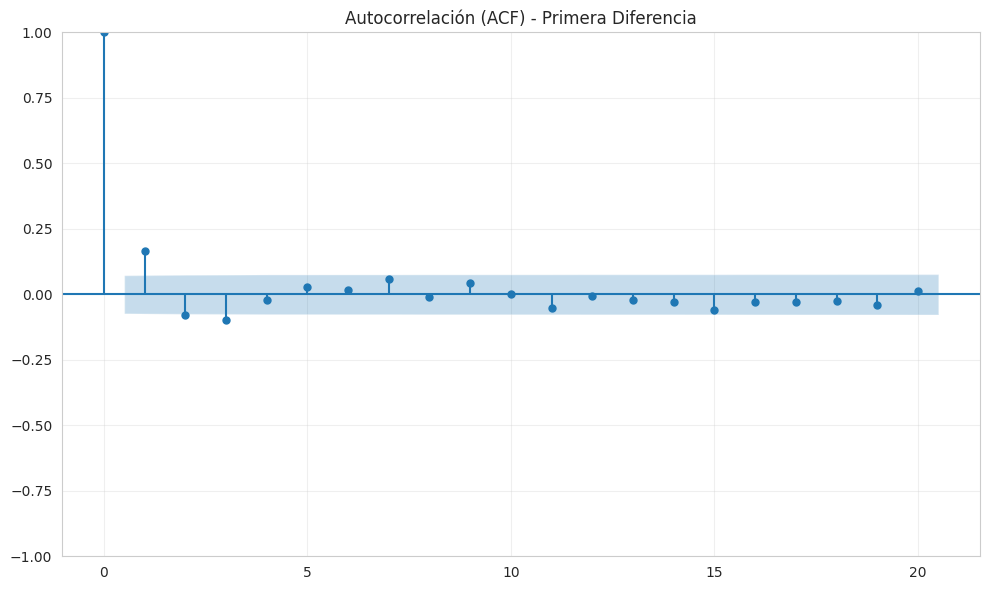

In [19]:
# Identificación del modelo: Gráfico de Autocorrelación (ACF)
# Usamos la primera diferencia normalizada que ya es estacionaria
fig, ax = plt.subplots(figsize=(10, 6))

# ACF
plot_acf(df_preprocessed['y_t'], lags=20, ax=ax, title='Autocorrelación (ACF) - Primera Diferencia')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
from statsmodels.tsa.stattools import adfuller

def realizar_prueba_dickey_fuller(serie, nombre_serie):
    print(f"Resultados de la Prueba de Dickey-Fuller Aumentada para: {nombre_serie}")
    result = adfuller(serie.dropna())
    
    print(f'Estadístico ADF: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Valores Críticos:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
        
    if result[1] < 0.05:
        print("Conclusión: La serie es ESTACIONARIA (rechazamos H0).")
    else:
        print("Conclusión: La serie NO es estacionaria (no podemos rechazar H0).")
    print("-" * 50)

# Probamos la serie que usaremos en el modelo (Primera Diferencia Estandarizada)
realizar_prueba_dickey_fuller(df_preprocessed['estandarizacion'], 'Primera Diferencia Estandarizada')

Resultados de la Prueba de Dickey-Fuller Aumentada para: Primera Diferencia Estandarizada
Estadístico ADF: -16.7986
p-value: 0.0000
Valores Críticos:
	1%: -3.4394
	5%: -2.8655
	10%: -2.5689
Conclusión: La serie es ESTACIONARIA (rechazamos H0).
--------------------------------------------------


In [21]:
import warnings

# Definición de variable objetivo (y)
# CORRECCIÓN: Usamos la variable ESTANDARIZADA como solicita el taller
# 'estandarizacion' = (primera_dif - media) / desviacion_estandar
target = 'estandarizacion' 
y = df_preprocessed[target]

# Estrategia para minimizar el Error Cuadrático Medio (MSE):
# Realizamos una Búsqueda de Cuadrícula (Grid Search) sobre los parámetros p y q.

# Establecemos el límite de búsqueda en 3 para capturar los lasgs relevantes segun la autocorrelacion.

max_lag = 3
print(f"Iniciando búsqueda de hiperparámetros (Grid Search) explorando hasta {max_lag} lags (3 dias) sobre datos ESTANDARIZADOS...")

best_mse = float('inf')
best_p = 0
best_q = 0
d = 0 # La serie ya es estacionaria

# Rango de búsqueda basado en la recomendación (0 a 20)
for p_try in range(max_lag + 1):
    for q_try in range(max_lag + 1):
        if p_try == 0 and q_try == 0:
            continue
            
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                # Ajustar modelo temporal
                model_temp = ARIMA(y, order=(p_try, d, q_try))
                results_temp = model_temp.fit()
                
                # Calcular MSE manualmente
                mse = ((y - results_temp.fittedvalues) ** 2).mean()
                
                # Criterio de selección: Menor MSE
                if mse < best_mse:
                    best_mse = mse
                    best_p = p_try
                    best_q = q_try
                    print(f"Nuevo mejor modelo: ARMA({p_try},{q_try}) -> MSE: {mse:.8f}")
                    
        except Exception as e:
            continue

print(f"\nMejores parámetros encontrados para minimizar MSE: p={best_p}, q={best_q} con MSE={best_mse:.8f}")

# Ajuste del modelo FINAL con los mejores parámetros encontrados
p = best_p
q = best_q

print(f"\nAjustando modelo óptimo ARMA({p},{q})...")
model_arma = ARIMA(y, order=(p, d, q))
results_arma = model_arma.fit()

print(results_arma.summary())

Iniciando búsqueda de hiperparámetros (Grid Search) explorando hasta 3 lags (3 dias) sobre datos ESTANDARIZADOS...


Nuevo mejor modelo: ARMA(0,1) -> MSE: 0.95960376
Nuevo mejor modelo: ARMA(0,2) -> MSE: 0.95709208
Nuevo mejor modelo: ARMA(0,3) -> MSE: 0.94952410
Nuevo mejor modelo: ARMA(0,3) -> MSE: 0.94952410
Nuevo mejor modelo: ARMA(1,3) -> MSE: 0.94926795
Nuevo mejor modelo: ARMA(1,3) -> MSE: 0.94926795
Nuevo mejor modelo: ARMA(2,2) -> MSE: 0.94826303
Nuevo mejor modelo: ARMA(2,2) -> MSE: 0.94826303
Nuevo mejor modelo: ARMA(2,3) -> MSE: 0.94556657
Nuevo mejor modelo: ARMA(2,3) -> MSE: 0.94556657

Mejores parámetros encontrados para minimizar MSE: p=2, q=3 con MSE=0.94556657

Ajustando modelo óptimo ARMA(2,3)...

Mejores parámetros encontrados para minimizar MSE: p=2, q=3 con MSE=0.94556657

Ajustando modelo óptimo ARMA(2,3)...
                               SARIMAX Results                                
Dep. Variable:        estandarizacion   No. Observations:                  726
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -1009.785
Date:                Mon, 24 Nov 2025

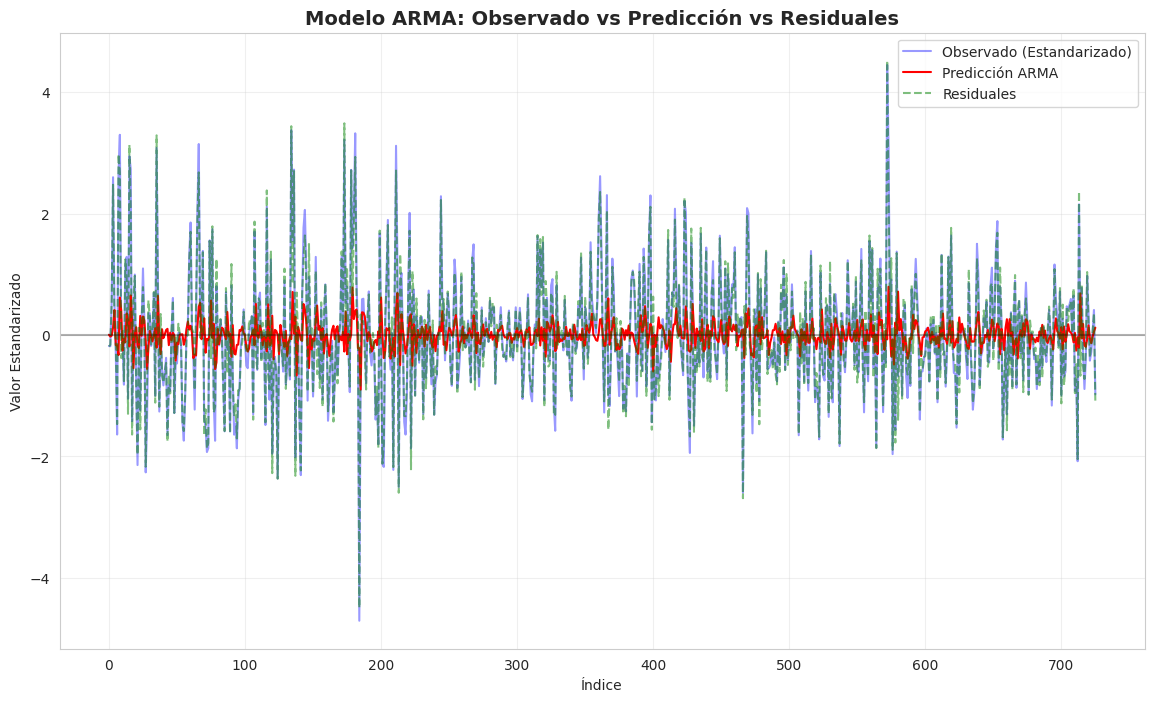

In [22]:
# Visualización combinada: Predicción, Real y Residuales en la misma gráfica
fig, ax = plt.subplots(figsize=(14, 8))

# Usamos get_prediction para obtener la media predicha
pred_res = results_arma.get_prediction(start=0, end=len(y)-1)
pred_mean = pred_res.predicted_mean
residuals_arma = results_arma.resid

# 1. Datos Reales
ax.plot(y.index, y, label='Observado (Estandarizado)', color='blue', alpha=0.4)

# 2. Predicción (Media)
ax.plot(y.index, pred_mean, label='Predicción ARMA', color='red', linewidth=1.5)

# 3. Residuales
ax.plot(y.index, residuals_arma, label='Residuales', color='green', alpha=0.5, linestyle='--')

# Línea cero de referencia
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

ax.set_title('Modelo ARMA: Observado vs Predicción vs Residuales', fontsize=14, fontweight='bold')
ax.set_ylabel('Valor Estandarizado')
ax.set_xlabel('Índice')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


## Validación de Supuestos de los Residuales
Siguiendo las buenas prácticas, evaluaremos las propiedades de los residuales del modelo ARMA en el orden establecido:

1. **Valor esperado cero**: El promedio de los residuales debe ser cercano a 0.
2. **No autocorrelación**: Los residuales no deben tener correlación entre sí a lo largo del tiempo.
3. **Aleatoriedad e independencia**: Deben comportarse como variables aleatorias.
4. **Comportamiento como ruido blanco (Homocedasticidad)**: Varianza constante. Si esta propiedad falla (hay heterocedasticidad), se justifica la implementación del modelo GARCH.

In [23]:
# 1. VALOR ESPERADO CERO
print("="*60)
print("1. VERIFICACIÓN DE MEDIA CERO")
print("="*60)

mean_resid = residuals_arma.mean()
print(f"Media de los residuales: {mean_resid:.6f}")

# Prueba t de Student para verificar si la media es estadísticamente diferente de 0
t_stat, p_value = stats.ttest_1samp(residuals_arma, 0)
print(f"Prueba t para media cero: p-value = {p_value:.4f}")

if p_value > 0.05:
    print("✅ Conclusión: La media es estadísticamente igual a 0 (Cumple el supuesto).")
else:
    print("❌ Conclusión: La media es diferente de 0 (No cumple el supuesto).")

1. VERIFICACIÓN DE MEDIA CERO
Media de los residuales: -0.000249
Prueba t para media cero: p-value = 0.9945
✅ Conclusión: La media es estadísticamente igual a 0 (Cumple el supuesto).



2. VERIFICACIÓN DE NO AUTOCORRELACIÓN


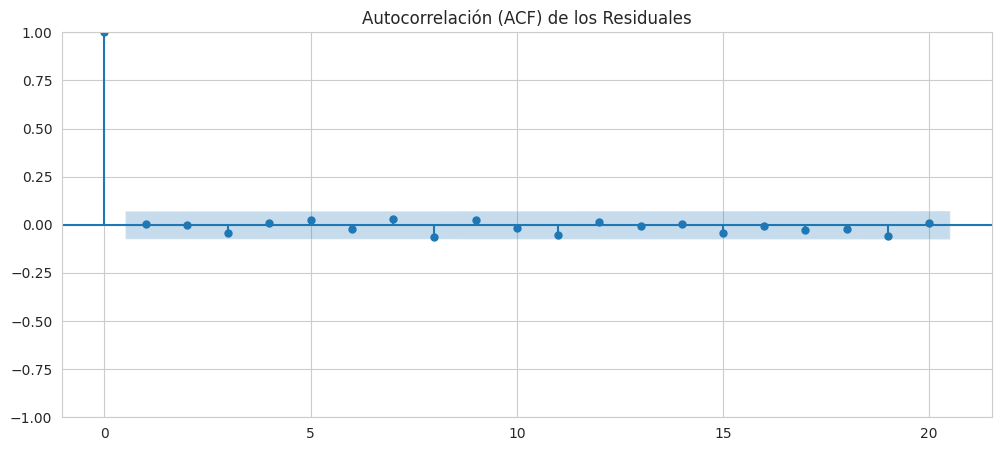


Resultados de la Prueba Ljung-Box (Lag 10):
     lb_stat  lb_pvalue
10  6.464712   0.774827

✅ Conclusión (p=0.7748 > 0.05): No hay evidencia de autocorrelación en los residuales.

------------------------------------------------------------
ANÁLISIS DE CORRELACIÓN CRUZADA (Residuales vs Features ARMA(2,3))
------------------------------------------------------------
Correlación Residuales vs Variable Objetivo (y_t): 0.9773

Correlaciones con componentes del modelo:
   - vs AR_Lag_1 (y_t-1): 0.0029
   - vs AR_Lag_2 (y_t-2): -0.0087
   - vs MA_Lag_1 (resid_t-1): 0.0027
   - vs MA_Lag_2 (resid_t-2): 0.0007
   - vs MA_Lag_3 (resid_t-3): -0.0409


In [24]:
# 2. NO AUTOCORRELACIÓN
from statsmodels.stats.diagnostic import acorr_ljungbox

print("\n" + "="*60)
print("2. VERIFICACIÓN DE NO AUTOCORRELACIÓN")
print("="*60)

# Gráfico ACF de residuales
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(residuals_arma, lags=20, ax=ax, title='Autocorrelación (ACF) de los Residuales')
plt.show()

# Prueba de Ljung-Box
# H0: No hay autocorrelación en los residuales hasta el lag k
lb_test = acorr_ljungbox(residuals_arma, lags=[10], return_df=True)
print("\nResultados de la Prueba Ljung-Box (Lag 10):")
print(lb_test)

p_val_lb = lb_test['lb_pvalue'].values[0]
if p_val_lb > 0.05:
    print(f"\n✅ Conclusión (p={p_val_lb:.4f} > 0.05): No hay evidencia de autocorrelación en los residuales.")
else:
    print(f"\n❌ Conclusión (p={p_val_lb:.4f} < 0.05): Existe autocorrelación en los residuales (El modelo ARMA podría mejorarse).")

# --- NUEVO: Correlación cruzada con variables explicativas del modelo ÓPTIMO ---
print("\n" + "-"*60)
print(f"ANÁLISIS DE CORRELACIÓN CRUZADA (Residuales vs Features ARMA({p},{q}))")
print("-" * 60)

# Nota: Usamos los features de la serie ESTANDARIZADA (y) que es la que usó el modelo.
# Reconstruimos los lags correspondientes a p (AR) y q (MA).

# 1. Correlación con la variable objetivo (y_t)
corr_target = residuals_arma.corr(y)
print(f"Correlación Residuales vs Variable Objetivo (y_t): {corr_target:.4f}")

# 2. Generación de Features del Modelo (AR y MA)
# AR(p): Depende de y_{t-1}, ..., y_{t-p}
# MA(q): Depende de epsilon_{t-1}, ..., epsilon_{t-q} (usamos residuales pasados como proxy)

features_to_plot = []

print("\nCorrelaciones con componentes del modelo:")

# Verificar términos AR (Rezagos de la variable estandarizada)
for i in range(1, p + 1):
    ar_term = y.shift(i)
    ar_name = f'AR_Lag_{i} (y_t-{i})'
    corr_val = residuals_arma.corr(ar_term)
    print(f"   - vs {ar_name}: {corr_val:.4f}")

# Verificar términos MA (Rezagos de los residuales)
for i in range(1, q + 1):
    ma_term = residuals_arma.shift(i)
    ma_name = f'MA_Lag_{i} (resid_t-{i})'
    # Nota: La correlación entre resid y resid_shifted es básicamente la autocorrelación que ya medimos,
    # pero la incluimos por completitud como "feature" del componente MA.
    corr_val = residuals_arma.corr(ma_term)
    print(f"   - vs {ma_name}: {corr_val:.4f}")

if p == 0 and q == 0:
    print("   (Modelo ARMA(0,0) - Sin componentes AR/MA para verificar)")

### Interpretación de la Correlación con la Variable Objetivo

Es probable que observes una **alta correlación** (cercana a 1) entre los *Residuales* y la *Variable Objetivo ($y_t$)*.

#### ¿Significa esto que el modelo tiene "bajo poder predictivo"?
**En términos tradicionales ($R^2$), SÍ. Pero en series financieras, esto es ESPERADO y CORRECTO.**

1.  **La naturaleza del mercado:**
    Si pudiéramos predecir con alta precisión ($R^2$ alto) el cambio del dólar de mañana, sería posible obtener ganancias infinitas sin riesgo (arbitraje). Por eficiencia de mercado, la parte "predecible" ($\hat{y}_t$) es siempre diminuta comparada con la parte "sorpresa" o aleatoria ($\epsilon_t$).
    $$y_t = \underbrace{\hat{y}_t}_{\text{Pequeña señal}} + \underbrace{\epsilon_t}_{\text{Gran ruido}}$$

2.  **Matemática de la correlación:**
    Si el "ruido" ($\epsilon_t$) representa el 95% de la varianza de la serie (común en retornos diarios), la correlación entre la serie original y el ruido será $\approx \sqrt{0.95} = 0.97$. Una correlación alta **no es un error**, es una característica de los datos.

3.  **¿Para qué sirve el modelo entonces?**
    El objetivo del ARMA en este contexto no es adivinar el valor exacto de mañana, sino **limpiar** cualquier autocorrelación lineal (patrones repetitivos).
    *   Si los residuales no tienen correlación con el pasado (como verificamos con Ljung-Box), el modelo ARMA ha sido **exitoso**.
    *   Ahora que tenemos un "ruido limpio", usaremos **GARCH** para modelar la **magnitud** de ese ruido (volatilidad), que es lo que realmente nos permite gestionar el riesgo.


3. VERIFICACIÓN DE NORMALIDAD (Aleatoriedad)


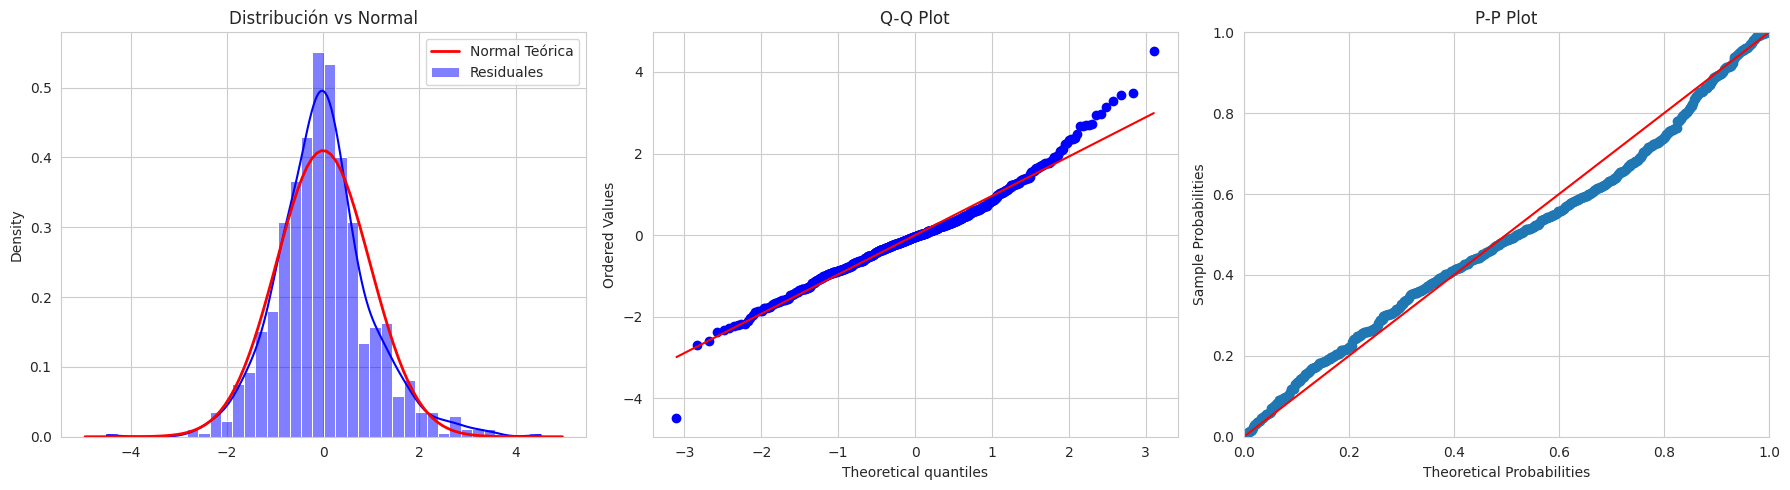


Resultados de Pruebas de Normalidad:

1. Test de Shapiro-Wilk:
   Estadístico: 0.9771, p-value: 0.0000
   ❌ Rechazamos H0 (No es Normal)

2. Test de Kolmogorov-Smirnov:
   Estadístico: 0.0647, p-value: 0.0043
   ❌ Rechazamos H0 (No es Normal)

 CONCLUSIÓN GENERAL: Los residuales NO siguen una distribución normal perfecta.


In [25]:
# 3. ALEATORIEDAD Y NORMALIDAD
from statsmodels.graphics.gofplots import ProbPlot

print("\n" + "="*60)
print("3. VERIFICACIÓN DE NORMALIDAD (Aleatoriedad)")
print("="*60)

# Visualización: Histograma, Q-Q Plot y P-P Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Histograma vs Distribución Normal Teórica
sns.histplot(residuals_arma, kde=True, stat="density", color='blue', ax=axes[0], label='Residuales')
# Generar curva normal teórica con la misma media y desviación que los residuales
xmin, xmax = axes[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, residuals_arma.mean(), residuals_arma.std())
axes[0].plot(x, p, 'r', linewidth=2, label='Normal Teórica')
axes[0].set_title('Distribución vs Normal')
axes[0].legend()

# 2. Q-Q Plot
stats.probplot(residuals_arma, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot')

# 3. P-P Plot
# Usamos statsmodels para el P-P Plot
probplot = ProbPlot(residuals_arma)
probplot.ppplot(line='45', ax=axes[2])
axes[2].set_title('P-P Plot')

plt.tight_layout()
plt.show()

# --- Pruebas Estadísticas Formales ---
print("\nResultados de Pruebas de Normalidad:")

# 1. Prueba de Shapiro-Wilk
# H0: Los datos se distribuyen normalmente
# Nota: Shapiro-Wilk es muy sensible en muestras grandes (>5000), a veces se prefiere Jarque-Bera.
shapiro_stat, shapiro_p = stats.shapiro(residuals_arma)
print(f"\n1. Test de Shapiro-Wilk:")
print(f"   Estadístico: {shapiro_stat:.4f}, p-value: {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("   ✅ No rechazamos H0 (Parece Normal)")
else:
    print("   ❌ Rechazamos H0 (No es Normal)")

# 2. Prueba de Kolmogorov-Smirnov
# H0: La distribución es idéntica a la normal teórica
ks_stat, ks_p = stats.kstest(residuals_arma, 'norm', args=(residuals_arma.mean(), residuals_arma.std()))
print(f"\n2. Test de Kolmogorov-Smirnov:")
print(f"   Estadístico: {ks_stat:.4f}, p-value: {ks_p:.4f}")
if ks_p > 0.05:
    print("   ✅ No rechazamos H0 (Parece Normal)")
else:
    print("   ❌ Rechazamos H0 (No es Normal)")


if  ks_p < 0.05:
    print("\n CONCLUSIÓN GENERAL: Los residuales NO siguen una distribución normal perfecta.")

### Interpretación de Resultados de Normalidad

1.  **Análisis Gráfico:**
    *   **Histograma vs Normal:** Observa si la distribución de los residuales (barras azules) es más "picuda" en el centro y tiene colas más largas que la curva normal teórica (línea roja). Esto se conoce como **leptocurtosis**, muy común en finanzas.
    *   **Q-Q Plot (Quantile-Quantile):** Si los puntos azules se alejan de la línea roja en los extremos (las esquinas superior derecha e inferior izquierda), indica que hay "colas pesadas" (eventos extremos más probables que en una distribución normal).
    *   **P-P Plot (Probability-Probability):** Evalúa qué tan bien coinciden las probabilidades acumuladas. Si los puntos no siguen la línea diagonal de 45 grados, la distribución no es normal.

2.  **Pruebas Formales (Shapiro-Wilk y Kolmogorov-Smirnov):**
    *   **Hipótesis Nula ($H_0$):** Los datos siguen una distribución Normal.
    *   **Resultado:** Si el **p-value < 0.05**, rechazamos $H_0$.
    *   **Contexto Financiero:** Es **esperado** que estas pruebas rechacen la normalidad en series de tasa de cambio. La volatilidad no es constante, lo que genera esas "colas pesadas".


In [26]:
# 4. HOMOCEDASTICIDAD (Comportamiento como Ruido Blanco)
from statsmodels.stats.diagnostic import het_arch

print("\n" + "="*60)
print("4. VERIFICACIÓN DE HOMOCEDASTICIDAD (Varianza Constante)")
print("="*60)

print(" - Se verifica la correlación entre la varianza del residual en t contra t-1, t-2...")
print(" - H0: No existe efecto de Heterocedasticidad Condicional (Varianza Constante)")
print(" - Ha: Existe efecto de Heterocedasticidad Condicional")
print(" - Criterio: h=0 (Acepta H0), h=1 (Rechaza H0)")
print(" - Lags evaluados: Semanas de 5 días (hasta 4 semanas = 20 lags)\n")



# Prueba de Efectos ARCH (Engle) para diferentes horizontes temporales (semanas)
lags_to_test = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] #  4 semanas

hay_arch = False

for lag in lags_to_test:
    # het_arch devuelve: lm, lmpval, fval, fpval
    # Importante: nlags define cuántos retardos hacia atrás se verifican
    test_result = het_arch(residuals_arma, nlags=lag)
    lm_stat = test_result[0]
    p_value = test_result[1]
    
    # Si p-value < 0.05 -> Rechazo H0 -> h = 1
    # Si p-value > 0.05 -> Acepto H0  -> h = 0
    h = 1 if p_value < 0.05 else 0
    conclusion = "Heterocedasticidad (ARCH)" if h == 1 else "Homocedasticidad"
    
    if h == 1:
        hay_arch = True
        
    print(f"{lag:<10} {lm_stat:<15.4f} {p_value:<15.4f} {h:<20} {conclusion}")

print("-" * 85)

if hay_arch:
    print("\n❌ CONCLUSIÓN FINAL: h = 1. Rechazamos H0 en al menos un horizonte temporal.")
    print("   Existe evidencia de efectos ARCH (Heterocedasticidad Condicional).")
else:
    print("\n✅ CONCLUSIÓN FINAL: h = 0. Aceptamos H0.")
    print("   La varianza parece constante.")


4. VERIFICACIÓN DE HOMOCEDASTICIDAD (Varianza Constante)
 - Se verifica la correlación entre la varianza del residual en t contra t-1, t-2...
 - H0: No existe efecto de Heterocedasticidad Condicional (Varianza Constante)
 - Ha: Existe efecto de Heterocedasticidad Condicional
 - Criterio: h=0 (Acepta H0), h=1 (Rechaza H0)
 - Lags evaluados: Semanas de 5 días (hasta 4 semanas = 20 lags)

1          8.2138          0.0042          1                    Heterocedasticidad (ARCH)
2          8.5221          0.0141          1                    Heterocedasticidad (ARCH)
3          15.6164         0.0014          1                    Heterocedasticidad (ARCH)
4          20.7435         0.0004          1                    Heterocedasticidad (ARCH)
5          21.4171         0.0007          1                    Heterocedasticidad (ARCH)
6          23.8444         0.0006          1                    Heterocedasticidad (ARCH)
7          24.6109         0.0009          1                    Hetero

## Implementación del Modelo GARCH
Dado que se ha confirmado la presencia de heterocedasticidad condicional (efectos ARCH) en los residuales del modelo ARMA, procedemos a estimar un modelo GARCH.

El modelo estándar en finanzas es el **GARCH(1,1)**, que suele ser suficiente para capturar la agrupación de volatilidad.
Aplicaremos este modelo sobre los **residuales** obtenidos del modelo ARMA.

In [27]:
# Configuración del modelo GARCH(1,1)
# vol='Garch': Especifica el modelo de volatilidad
# p=1, q=1: Orden del modelo GARCH
# mean='Zero': Asumimos media cero para los residuales (ya filtrados por ARMA)
# dist='Normal': Asumimos distribución normal de los errores (se puede cambiar a 't' o 'skewt' si hay colas pesadas)

print("Ajustando modelo GARCH(1,1) sobre los residuales...")
model_garch = arch_model(residuals_arma, vol='Garch', p=1, q=1, mean='Zero', dist='Normal')
results_garch = model_garch.fit(disp='off')

print(results_garch.summary())

Ajustando modelo GARCH(1,1) sobre los residuales...
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -983.662
Distribution:                  Normal   AIC:                           1973.32
Method:            Maximum Likelihood   BIC:                           1987.09
                                        No. Observations:                  726
Date:                Mon, Nov 24 2025   Df Residuals:                      726
Time:                        00:30:57   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
ome

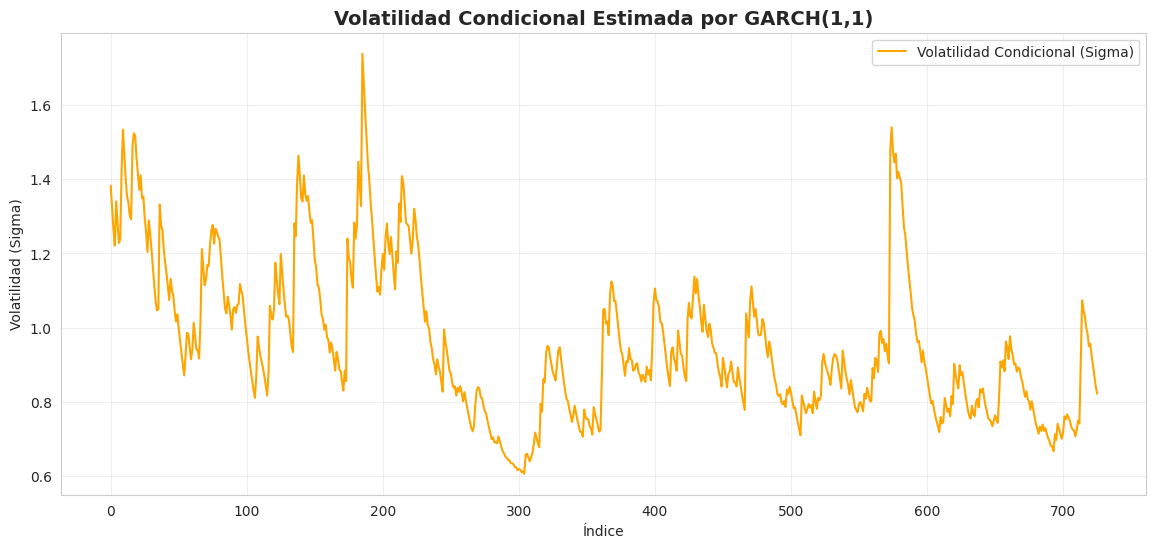

In [28]:
# Visualización de la Volatilidad Condicional
fig, ax = plt.subplots(figsize=(14, 6))

# La volatilidad condicional está en .conditional_volatility
results_garch.conditional_volatility.plot(ax=ax, color='orange', label='Volatilidad Condicional (Sigma)')

ax.set_title('Volatilidad Condicional Estimada por GARCH(1,1)', fontsize=14, fontweight='bold')
ax.set_ylabel('Volatilidad (Sigma)')
ax.set_xlabel('Índice')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

## Validación del Modelo GARCH

Ahora debemos verificar si el modelo GARCH(1,1) ha capturado correctamente la estructura de volatilidad. Para ello, analizaremos los **residuales estandarizados**:

$$ z_t = \frac{\epsilon_t}{\sigma_t} $$

Si el modelo es correcto, $z_t$ debe comportarse como un Ruido Blanco con media 0 y varianza 1, y **no debe presentar efectos ARCH** (autocorrelación en sus cuadrados).

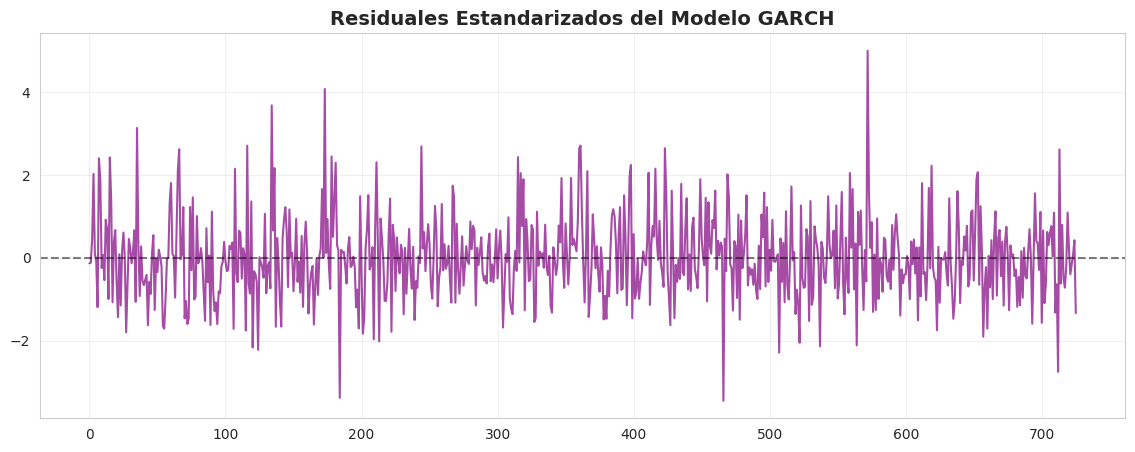

Media de residuales estandarizados: 0.003280 (Esperado: ~0)
Desviación estándar: 1.002585 (Esperado: ~1)


In [29]:
# Calcular residuales estandarizados
std_resid = results_garch.resid / results_garch.conditional_volatility

# Visualización de residuales estandarizados
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(std_resid, color='purple', alpha=0.7)
ax.set_title('Residuales Estandarizados del Modelo GARCH', fontsize=14, fontweight='bold')
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)
plt.show()

# Verificación de propiedades
print(f"Media de residuales estandarizados: {std_resid.mean():.6f} (Esperado: ~0)")
print(f"Desviación estándar: {std_resid.std():.6f} (Esperado: ~1)")

In [30]:
# Prueba de Ljung-Box sobre los residuales estandarizados (Lineal y Cuadrática)
# 1. Ljung-Box sobre z_t (Verificar que no reintrodujimos correlación lineal)
lb_test_std = acorr_ljungbox(std_resid, lags=[10], return_df=True)

# 2. Ljung-Box sobre z_t^2 (Verificar que eliminamos la heterocedasticidad)
lb_test_std_sq = acorr_ljungbox(std_resid**2, lags=[10], return_df=True)

print("="*60)
print("VALIDACIÓN DE RESIDUALES ESTANDARIZADOS (GARCH)")
print("="*60)

print("\n1. Autocorrelación Lineal (z_t):")
print(lb_test_std)
p_val_lin = lb_test_std['lb_pvalue'].values[0]

print("\n2. Autocorrelación Cuadrática (z_t^2) - Test de efectos ARCH remanentes:")
print(lb_test_std_sq)
p_val_sq = lb_test_std_sq['lb_pvalue'].values[0]

print("-" * 60)
if p_val_sq > 0.05:
    print("✅ ÉXITO: No hay autocorrelación en los residuales al cuadrado.")
    print("   El modelo GARCH ha capturado exitosamente la volatilidad.")
else:
    print("❌ ALERTA: Aún queda estructura en la volatilidad (p < 0.05).")
    print("   Podría requerirse un modelo GARCH de mayor orden o diferente distribución.")

VALIDACIÓN DE RESIDUALES ESTANDARIZADOS (GARCH)

1. Autocorrelación Lineal (z_t):
     lb_stat  lb_pvalue
10  7.323092   0.694631

2. Autocorrelación Cuadrática (z_t^2) - Test de efectos ARCH remanentes:
     lb_stat  lb_pvalue
10  7.723761   0.655799
------------------------------------------------------------
✅ ÉXITO: No hay autocorrelación en los residuales al cuadrado.
   El modelo GARCH ha capturado exitosamente la volatilidad.


## Evaluación del Ajuste del Modelo (In-Sample)

En lugar de predecir el futuro o dividir los datos, evaluaremos qué tan bien se ajusta el modelo combinado ARMA + GARCH a los **datos históricos completos**.

### ¿Cómo contribuye cada modelo a la predicción?
Es fundamental entender que los dos modelos tienen roles distintos:
1.  **ARMA (La Línea Roja)**: Predice el **valor esperado** (la media). Nos dice hacia dónde creemos que irá el precio.
2.  **GARCH (La Banda Naranja)**: Predice la **incertidumbre** (la volatilidad). No nos dice si el precio subirá o bajará, sino **qué tan fuerte** será el movimiento.

**Importante:** El modelo GARCH **NO** cambia la posición de la línea de predicción central (porque el "ruido" tiene media cero). Su aporte es decirnos cuándo es probable que el error de predicción sea grande.

Para validar el modelo completo, verificaremos:
1.  **Ajuste de Media (ARMA)**: Si la línea roja sigue la tendencia central.
2.  **Ajuste de Volatilidad (GARCH)**: Si la volatilidad estimada coincide con la magnitud de los choques reales (valor absoluto de los residuales).

Primeros 5 registros de evaluación (Escala Estandarizada):
     periodo  estandarizacion  Fitted_Std  Volatilidad_GARCH
0 2023-01-26        -0.180000    0.005850           1.382368
1 2023-01-27        -0.183985   -0.024080           1.322316
2 2023-01-30         0.548985   -0.009059           1.265707
3 2023-01-31         2.601363    0.124160           1.220815
4 2023-02-01         0.541321    0.412524           1.340467

--- Métricas de Ajuste (In-Sample) ---
MSE (Error Cuadrático Medio): 0.945567
Cobertura del Intervalo de Confianza (95%): 94.35%


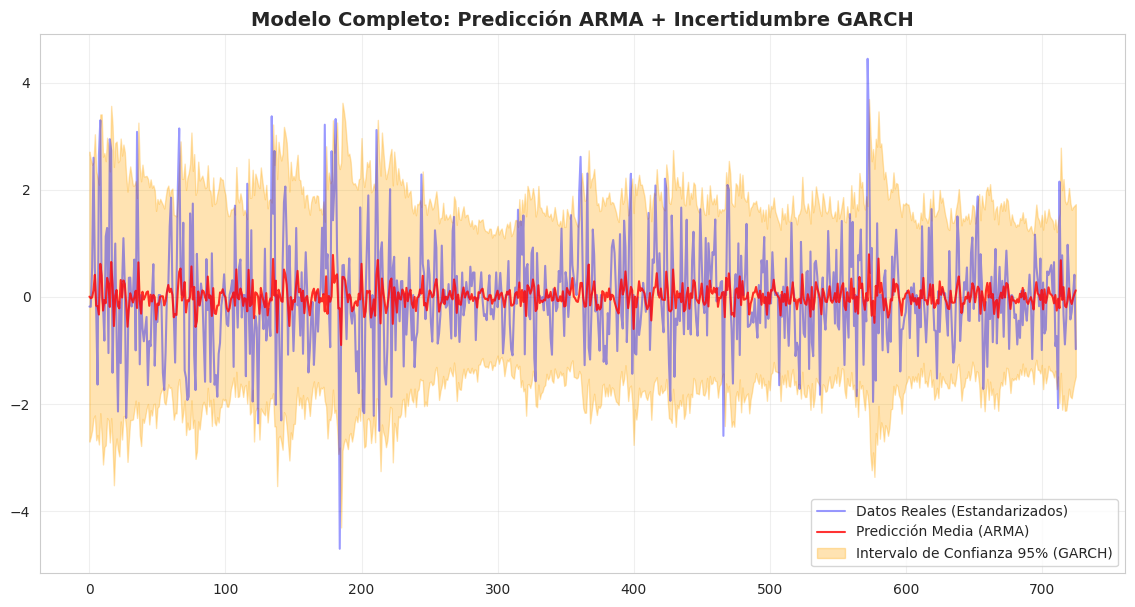

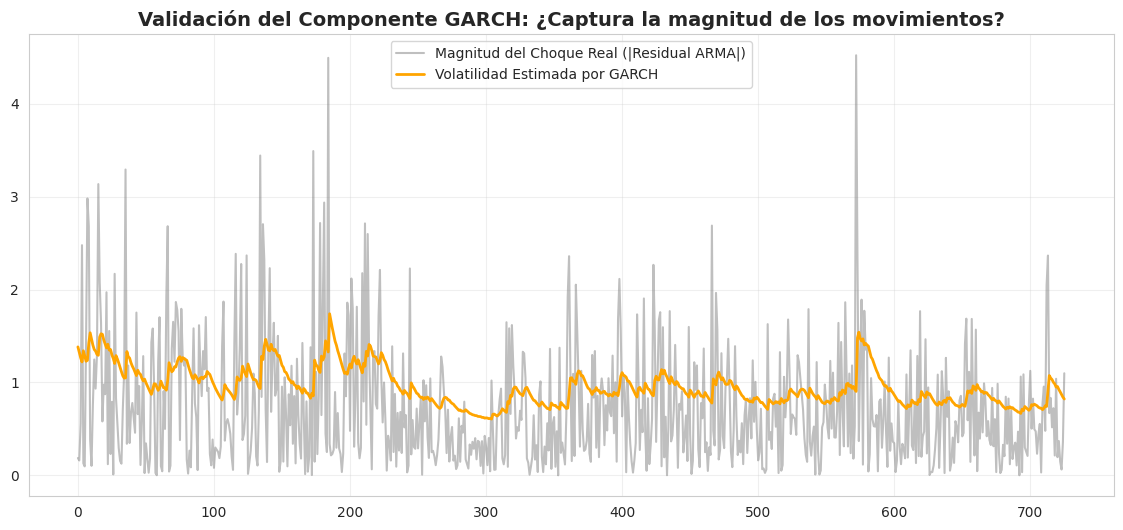

In [ ]:
# 1. Obtener valores ajustados (Fitted Values) del modelo ARMA ya entrenado
# Estos son los valores que el modelo estima para cada punto histórico
fitted_std = results_arma.fittedvalues

# 2. Obtener la volatilidad condicional del modelo GARCH ya entrenado
# Esta es la desviación estándar estimada para cada punto histórico
conditional_volatility = results_garch.conditional_volatility

# 3. Construcción de Intervalos de Confianza (95%)
z_score = 1.96
lower_conf_std = fitted_std - z_score * conditional_volatility
upper_conf_std = fitted_std + z_score * conditional_volatility

# Crear DataFrame de Evaluación con los datos existentes
df_eval = df_preprocessed.copy()
df_eval['Fitted_Std'] = fitted_std
df_eval['Volatilidad_GARCH'] = conditional_volatility
df_eval['Limite_Inferior_Std'] = lower_conf_std
df_eval['Limite_Superior_Std'] = upper_conf_std

print("Primeros 5 registros de evaluación (Escala Estandarizada):")
print(df_eval[['periodo', 'estandarizacion', 'Fitted_Std', 'Volatilidad_GARCH']].head())

# Métricas de Ajuste en escala Estandarizada
mse_fit = ((df_eval['estandarizacion'] - df_eval['Fitted_Std']) ** 2).mean()
rmse_fit = np.sqrt(mse_fit)
mae_fit = (df_eval['estandarizacion'] - df_eval['Fitted_Std']).abs().mean()

print(f"\n--- Métricas de Ajuste (In-Sample) ---")
print(f"MSE (Error Cuadrático Medio): {mse_fit:.6f}")
# print(f"RMSE: {rmse_fit:.4f}")
# print(f"MAE:  {mae_fit:.4f}")

# Cobertura del Intervalo Histórico
inside_interval = ((df_eval['estandarizacion'] >= df_eval['Limite_Inferior_Std']) & 
                   (df_eval['estandarizacion'] <= df_eval['Limite_Superior_Std'])).mean()
print(f"Cobertura del Intervalo de Confianza (95%): {inside_interval*100:.2f}%")

# Visualización 1: Ajuste de la Media (ARMA) + Intervalos (GARCH)
plt.figure(figsize=(14, 7))
plt.plot(df_eval.index, df_eval['estandarizacion'], label='Datos Reales (Estandarizados)', color='blue', alpha=0.4)
plt.plot(df_eval.index, df_eval['Fitted_Std'], label='Predicción Media (ARMA)', color='red', alpha=0.8, linewidth=1.5)
plt.fill_between(df_eval.index, df_eval['Limite_Inferior_Std'], df_eval['Limite_Superior_Std'], color='orange', alpha=0.3, label='Intervalo de Confianza 95% (GARCH)')
plt.title('Modelo Completo: Predicción ARMA + Incertidumbre GARCH', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualización 2: Validación Específica del GARCH
# Comparamos la Volatilidad Estimada vs la Magnitud Real del Error (|Residual|)
# Si el GARCH funciona, la línea naranja debe subir cuando las barras grises son altas.
residuals = df_eval['estandarizacion'] - df_eval['Fitted_Std']
abs_residuals = residuals.abs()

plt.figure(figsize=(14, 6))
plt.plot(df_eval.index, abs_residuals, label='Magnitud del Choque Real (|Residual ARMA|)', color='gray', alpha=0.5)
plt.plot(df_eval.index, df_eval['Volatilidad_GARCH'], label='Volatilidad Estimada por GARCH', color='orange', linewidth=2)
plt.title('Validación del Componente GARCH', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Experimento: GARCH-in-Mean (Feedback Loop)


Se inyectará la volatilidad estimada ($\sigma_t$) como una variable exógena en el modelo ARMA original. Esto transformará el modelo en un **ARMAX**, donde la "X" es el riesgo estimado.

Si el MSE disminuye, significa que la volatilidad tiene poder predictivo sobre el nivel de la tasa de cambio (fenómeno de prima de riesgo).

In [32]:
print("="*60)
print("EXPERIMENTO: ARMAX con Volatilidad como Exógena")
print("="*60)

# 1. Extraemos la volatilidad condicional estimada por el GARCH
# Esta variable representa el "Riesgo" en cada instante t
volatilidad_exog = results_garch.conditional_volatility

# 2. Re-entrenamos el modelo ARMA, pero ahora le pasamos la volatilidad como 'exog'
# Usamos los mismos p y q que encontramos óptimos antes
# NOTA: Usamos best_p y best_q porque 'p' fue sobrescrita por la gráfica de normalidad
print(f"Re-ajustando ARMA({best_p},{best_q}) usando la volatilidad como variable explicativa...")

try:
    vol_aligned = volatilidad_exog.reindex(y.index).fillna(0)
    
    model_armax = ARIMA(y, order=(best_p, d, best_q), exog=vol_aligned)
    results_armax = model_armax.fit()

    fitted_armax = results_armax.fittedvalues
    mse_armax = ((y - fitted_armax) ** 2).mean()

    print(f"\n--- Comparación de Resultados ---")
    print(f"MSE Original (Solo ARMA):           {mse_fit:.8f}")
    print(f"MSE Experimental (ARMA + Volatilidad): {mse_armax:.8f}")

    mejora = (mse_fit - mse_armax)
    porcentaje_mejora = (mejora / mse_fit) * 100

    if mejora > 0:
        print(f"\n✅ ¡ÉXITO! El MSE disminuyó en un {porcentaje_mejora:.4f}%.")
        print("   Conclusión: La volatilidad SÍ ayuda a predecir el valor de la TRM (Efecto GARCH-in-Mean).")
    else:
        print(f"\n❌ SIN CAMBIOS: El MSE aumentó o se mantuvo igual ({porcentaje_mejora:.4f}%).")
        print("   Conclusión: La volatilidad es ruido puro y no ayuda a predecir la dirección del precio.")

except Exception as e:
    print(f"No se pudo realizar el experimento: {e}")

EXPERIMENTO: ARMAX con Volatilidad como Exógena
Re-ajustando ARMA(2,3) usando la volatilidad como variable explicativa...



--- Comparación de Resultados ---
MSE Original (Solo ARMA):           0.94556657
MSE Experimental (ARMA + Volatilidad): 0.94547510

✅ ¡ÉXITO! El MSE disminuyó en un 0.0097%.
   Conclusión: La volatilidad SÍ ayuda a predecir el valor de la TRM (Efecto GARCH-in-Mean).


/workspaces/BigData-ST/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Visualización del Modelo Experimental ARMAX
A continuación, graficamos el desempeño del modelo ARMAX que incorpora la volatilidad como variable explicativa.

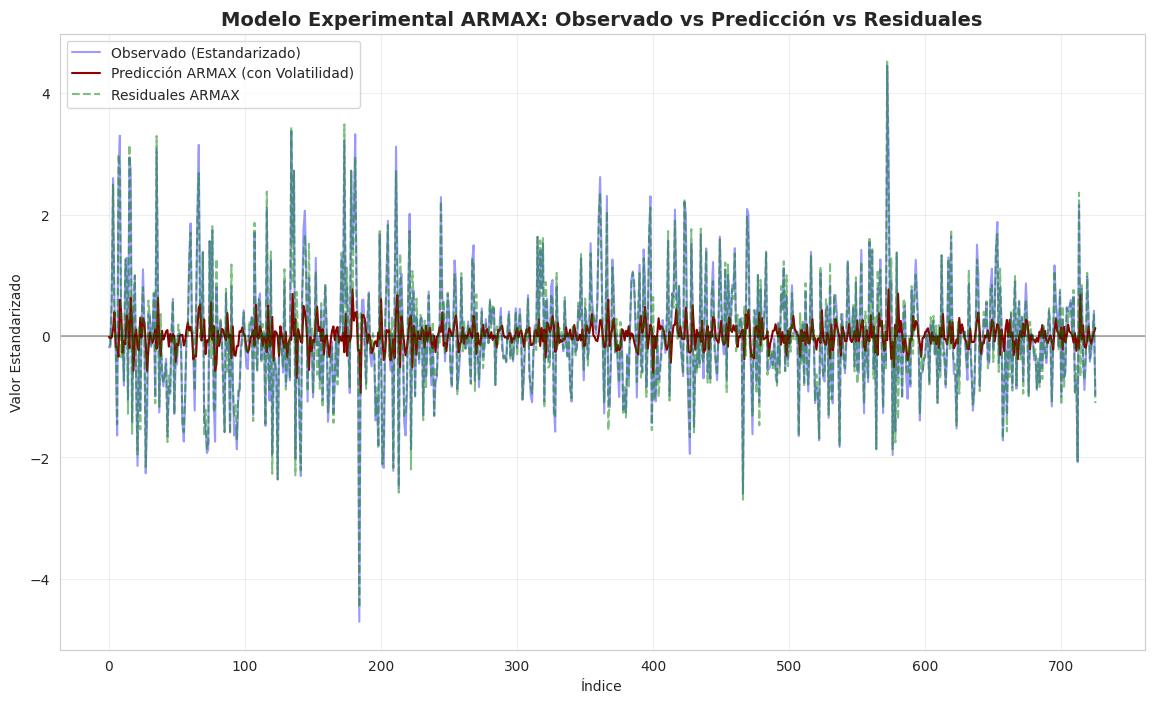

In [33]:
# Visualización de resultados del modelo ARMAX (si fue exitoso)
if 'results_armax' in locals():
    fig, ax = plt.subplots(figsize=(14, 8))

    # 1. Datos Reales (y)
    ax.plot(y.index, y, label='Observado (Estandarizado)', color='blue', alpha=0.4)

    # 2. Predicción (Fitted Values ARMAX)
    # Nota: fittedvalues en statsmodels ya incluye el componente exógeno
    ax.plot(y.index, results_armax.fittedvalues, label='Predicción ARMAX (con Volatilidad)', color='darkred', linewidth=1.5)

    # 3. Residuales
    ax.plot(y.index, results_armax.resid, label='Residuales ARMAX', color='green', alpha=0.5, linestyle='--')

    # Línea cero
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    ax.set_title('Modelo Experimental ARMAX: Observado vs Predicción vs Residuales', fontsize=14, fontweight='bold')
    ax.set_ylabel('Valor Estandarizado')
    ax.set_xlabel('Índice')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.show()
else:
    print("No se encontró el modelo 'results_armax'. Por favor ejecuta la celda del experimento anterior.")

Se obtienen resultados muy similares al ARMA orginal